<a href="https://colab.research.google.com/github/Rizukaf-id/DRPM-machine-learning/blob/main/drpm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [25]:
# from google.colab import drive
# drive.mount('/content/drive')

In [26]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

## Load Data

In [27]:
# file from google colab
# file = "/content/drive/MyDrive/DRPM 2024/code/data/after_preprocessed_data_with_emoji.csv"

# file from kaggle
file = "/kaggle/input/dataset-drpm/after_preprocessed_data_with_emoji - after_preprocessed_data_with_emoji.csv"
df = pd.read_csv(file)
df

,text,anotasi_gpt,emoji_berulang,new text,cleaning,case_folding,stopword_removal,stemming
0,",Sama bunda juga sedih ,mereka tulang punggung...",Non-Sarcasm,False,",Sama bunda juga sedih ,mereka tulang punggung...",Sama bunda juga sedih mereka tulang punggung k...,sama bunda juga sedih mereka tulang punggung k...,"['bunda', 'sedih', 'tulang', 'punggung', 'kelu...",bunda sedih tulang punggung keluarga gmn istri...
1,? Ada aplikasi lain kan? Lebay amat,Sarcasm,False,? Ada aplikasi lain kan? Lebay amat,Ada aplikasi lain kan Lebay amat,ada aplikasi lain kan lebay amat,"['aplikasi', 'lebay']",aplikasi lebay
2,????? Lawak UMKM ug mana? Yg harus di blokir i...,Sarcasm,False,????? Lawak UMKM ug mana? Yg harus di blokir i...,Lawak UMKM mana harus blokir itu produk impor ...,lawak umkm mana harus blokir itu produk impor ...,"['lawak', 'umkm', 'blokir', 'produk', 'impor',...",lawak umkm blokir produk impor cina lapang ker...
3,.. dan menghacurkan UMKM !,Sarcasm,False,.. dan menghacurkan UMKM !,dan menghacurkan UMKM,dan menghacurkan umkm,"['menghacurkan', 'umkm']",menghacurkan umkm
4,.jika tidak menggunakan teknologi manusia tida...,Sarcasm,False,.jika tidak menggunakan teknologi manusia tida...,jika tidak menggunakan teknologi manusia tidak...,jika tidak menggunakan teknologi manusia tidak...,"['teknologi', 'manusia', 'pergi', 'angkasa', '...",teknologi manusia pergi angkasa f x x negara k...
...,...,...,...,...,...,...,...,...
42931,Aaaa makasii banyak kak penjelasannya❤️penyamp...,Non-Sarcasm,False,Aaaa makasii banyak kak penjelasannya❤️penyamp...,Aaa makasii banyak kak penjelasannya penyampai...,aaa makasii banyak kak penjelasannya penyampai...,"['aaa', 'makasii', 'kak', 'penjelasannya', 'pe...",aaa makasii kak jelas sampai mudah bgt paham l...
42932,Aaaa makaaasih🫶🏻🫶🏻🫶🏻 masi on process krn pgn p...,Non-Sarcasm,False,Aaaa makaaasih🫶🏻🫶🏻🫶🏻 masi on process krn pgn p...,Aaa makaasih masi process krn pgn product stab...,aaa makaasih masi process krn pgn product stab...,"['aaa', 'makaasih', 'masi', 'process', 'pgn', ...",aaa makaasih mas process pgn product stabil ju...
42933,Aaaa luvsss🥺🥰 semoga aku terus bisa menginspir...,Non-Sarcasm,False,Aaaa luvsss (Menggambarkan keinginan akan sesu...,Aaa luvss semoga aku terus bisa menginspirasi yaa,aaa luvss semoga aku terus bisa menginspirasi yaa,"['aaa', 'luvss', 'semoga', 'menginspirasi', 'y...",aaa luvss moga inspirasi yaa
42934,"Aaaa jelas banget cara jelasinnya, makasih kak...",Non-Sarcasm,False,"Aaaa jelas banget cara jelasinnya, makasih kak...",Aaa jelas banget cara jelasinnya makasih kak a...,aaa jelas banget cara jelasinnya makasih kak a...,"['aaa', 'banget', 'jelasinnya', 'makasih', 'ka...",aaa banget jelasinnya makasih kak subscribe


In [28]:
count_sarcasm = df['anotasi_gpt'].value_counts()
count_sarcasm

anotasi_gpt
Non-Sarcasm    28074
Sarcasm        14862
Name: count, dtype: int64

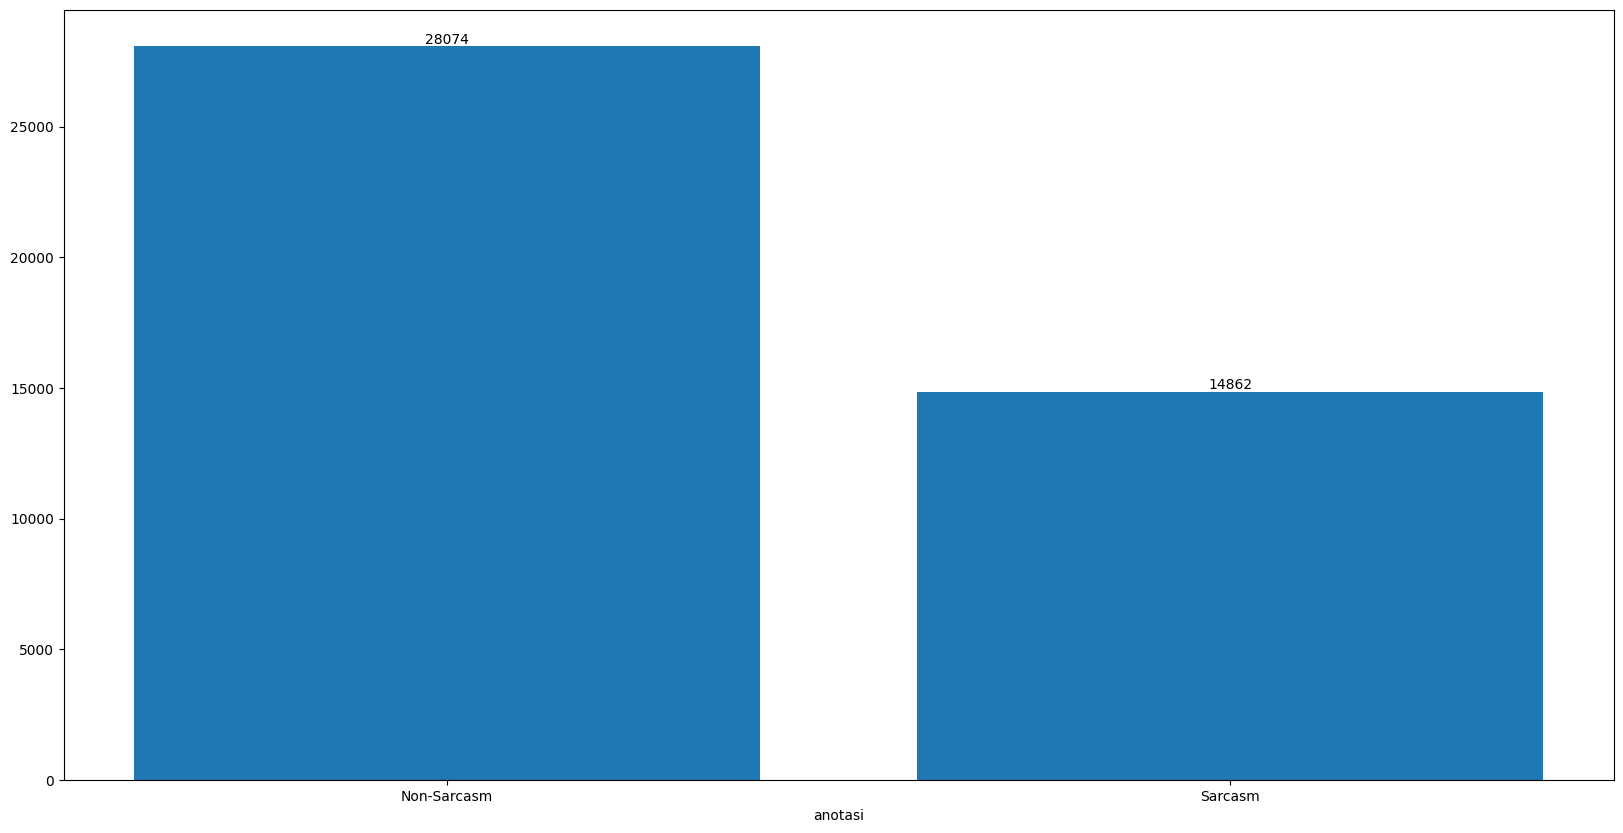

In [29]:
x = df['anotasi_gpt'].unique()
y = count_sarcasm
plt.figure(figsize=(20, 10))
# plt.bar(x, y)
plt.xlabel('anotasi')
plt.bar_label(plt.bar(x, y))
plt.show()

In [30]:
df["text"] == df["new text"]
similar_text = df["text"] == df["new text"]
count_similar_text = similar_text.value_counts()
count_similar_text

True     39725
False     3211
Name: count, dtype: int64

## Preprocess

In [31]:
df['anotasi_gpt'] = df['anotasi_gpt'].apply(lambda x: 0 if x == 'Non-Sarcasm' else 1)
df

,text,anotasi_gpt,emoji_berulang,new text,cleaning,case_folding,stopword_removal,stemming
0,",Sama bunda juga sedih ,mereka tulang punggung...",0,False,",Sama bunda juga sedih ,mereka tulang punggung...",Sama bunda juga sedih mereka tulang punggung k...,sama bunda juga sedih mereka tulang punggung k...,"['bunda', 'sedih', 'tulang', 'punggung', 'kelu...",bunda sedih tulang punggung keluarga gmn istri...
1,? Ada aplikasi lain kan? Lebay amat,1,False,? Ada aplikasi lain kan? Lebay amat,Ada aplikasi lain kan Lebay amat,ada aplikasi lain kan lebay amat,"['aplikasi', 'lebay']",aplikasi lebay
2,????? Lawak UMKM ug mana? Yg harus di blokir i...,1,False,????? Lawak UMKM ug mana? Yg harus di blokir i...,Lawak UMKM mana harus blokir itu produk impor ...,lawak umkm mana harus blokir itu produk impor ...,"['lawak', 'umkm', 'blokir', 'produk', 'impor',...",lawak umkm blokir produk impor cina lapang ker...
3,.. dan menghacurkan UMKM !,1,False,.. dan menghacurkan UMKM !,dan menghacurkan UMKM,dan menghacurkan umkm,"['menghacurkan', 'umkm']",menghacurkan umkm
4,.jika tidak menggunakan teknologi manusia tida...,1,False,.jika tidak menggunakan teknologi manusia tida...,jika tidak menggunakan teknologi manusia tidak...,jika tidak menggunakan teknologi manusia tidak...,"['teknologi', 'manusia', 'pergi', 'angkasa', '...",teknologi manusia pergi angkasa f x x negara k...
...,...,...,...,...,...,...,...,...
42931,Aaaa makasii banyak kak penjelasannya❤️penyamp...,0,False,Aaaa makasii banyak kak penjelasannya❤️penyamp...,Aaa makasii banyak kak penjelasannya penyampai...,aaa makasii banyak kak penjelasannya penyampai...,"['aaa', 'makasii', 'kak', 'penjelasannya', 'pe...",aaa makasii kak jelas sampai mudah bgt paham l...
42932,Aaaa makaaasih🫶🏻🫶🏻🫶🏻 masi on process krn pgn p...,0,False,Aaaa makaaasih🫶🏻🫶🏻🫶🏻 masi on process krn pgn p...,Aaa makaasih masi process krn pgn product stab...,aaa makaasih masi process krn pgn product stab...,"['aaa', 'makaasih', 'masi', 'process', 'pgn', ...",aaa makaasih mas process pgn product stabil ju...
42933,Aaaa luvsss🥺🥰 semoga aku terus bisa menginspir...,0,False,Aaaa luvsss (Menggambarkan keinginan akan sesu...,Aaa luvss semoga aku terus bisa menginspirasi yaa,aaa luvss semoga aku terus bisa menginspirasi yaa,"['aaa', 'luvss', 'semoga', 'menginspirasi', 'y...",aaa luvss moga inspirasi yaa
42934,"Aaaa jelas banget cara jelasinnya, makasih kak...",0,False,"Aaaa jelas banget cara jelasinnya, makasih kak...",Aaa jelas banget cara jelasinnya makasih kak a...,aaa jelas banget cara jelasinnya makasih kak a...,"['aaa', 'banget', 'jelasinnya', 'makasih', 'ka...",aaa banget jelasinnya makasih kak subscribe


In [32]:
df['emoji_berulang'] = df['emoji_berulang'].apply(lambda x: 0 if x == False else 1)
df_emoji_berulang = df
df_emoji_berulang

,text,anotasi_gpt,emoji_berulang,new text,cleaning,case_folding,stopword_removal,stemming
0,",Sama bunda juga sedih ,mereka tulang punggung...",0,0,",Sama bunda juga sedih ,mereka tulang punggung...",Sama bunda juga sedih mereka tulang punggung k...,sama bunda juga sedih mereka tulang punggung k...,"['bunda', 'sedih', 'tulang', 'punggung', 'kelu...",bunda sedih tulang punggung keluarga gmn istri...
1,? Ada aplikasi lain kan? Lebay amat,1,0,? Ada aplikasi lain kan? Lebay amat,Ada aplikasi lain kan Lebay amat,ada aplikasi lain kan lebay amat,"['aplikasi', 'lebay']",aplikasi lebay
2,????? Lawak UMKM ug mana? Yg harus di blokir i...,1,0,????? Lawak UMKM ug mana? Yg harus di blokir i...,Lawak UMKM mana harus blokir itu produk impor ...,lawak umkm mana harus blokir itu produk impor ...,"['lawak', 'umkm', 'blokir', 'produk', 'impor',...",lawak umkm blokir produk impor cina lapang ker...
3,.. dan menghacurkan UMKM !,1,0,.. dan menghacurkan UMKM !,dan menghacurkan UMKM,dan menghacurkan umkm,"['menghacurkan', 'umkm']",menghacurkan umkm
4,.jika tidak menggunakan teknologi manusia tida...,1,0,.jika tidak menggunakan teknologi manusia tida...,jika tidak menggunakan teknologi manusia tidak...,jika tidak menggunakan teknologi manusia tidak...,"['teknologi', 'manusia', 'pergi', 'angkasa', '...",teknologi manusia pergi angkasa f x x negara k...
...,...,...,...,...,...,...,...,...
42931,Aaaa makasii banyak kak penjelasannya❤️penyamp...,0,0,Aaaa makasii banyak kak penjelasannya❤️penyamp...,Aaa makasii banyak kak penjelasannya penyampai...,aaa makasii banyak kak penjelasannya penyampai...,"['aaa', 'makasii', 'kak', 'penjelasannya', 'pe...",aaa makasii kak jelas sampai mudah bgt paham l...
42932,Aaaa makaaasih🫶🏻🫶🏻🫶🏻 masi on process krn pgn p...,0,0,Aaaa makaaasih🫶🏻🫶🏻🫶🏻 masi on process krn pgn p...,Aaa makaasih masi process krn pgn product stab...,aaa makaasih masi process krn pgn product stab...,"['aaa', 'makaasih', 'masi', 'process', 'pgn', ...",aaa makaasih mas process pgn product stabil ju...
42933,Aaaa luvsss🥺🥰 semoga aku terus bisa menginspir...,0,0,Aaaa luvsss (Menggambarkan keinginan akan sesu...,Aaa luvss semoga aku terus bisa menginspirasi yaa,aaa luvss semoga aku terus bisa menginspirasi yaa,"['aaa', 'luvss', 'semoga', 'menginspirasi', 'y...",aaa luvss moga inspirasi yaa
42934,"Aaaa jelas banget cara jelasinnya, makasih kak...",0,0,"Aaaa jelas banget cara jelasinnya, makasih kak...",Aaa jelas banget cara jelasinnya makasih kak a...,aaa jelas banget cara jelasinnya makasih kak a...,"['aaa', 'banget', 'jelasinnya', 'makasih', 'ka...",aaa banget jelasinnya makasih kak subscribe


In [33]:
def has_repeated_words(text):
    words = text.split()
    for i in range(len(words) - 1):
        if words[i] == words[i + 1]:
            return 1
    return 0
def has_repeated_chars(text):
    return 1 if re.search(r'(.)\1{2,}', text) else 0
def has_repeated_symbols(text):
    return 1 if re.search(r'([!?,.#$%&*+=\-/\\:;<>@[\]^_`{|}~])\1{1,}', text) else 0
def has_repeated_combinations(text):
    return 1 if re.search(r'([a-zA-Z]{2,})\1+', text) else 0

In [34]:
df['is_repeat_word'] = df['text'].apply(has_repeated_words)
df['is_repeat_char'] = df['text'].apply(has_repeated_chars)
df['is_repeat_symbol'] = df['text'].apply(has_repeated_symbols)
df['is_repeat_combination'] = df['text'].apply(has_repeated_combinations)
df

,text,anotasi_gpt,emoji_berulang,new text,cleaning,case_folding,stopword_removal,stemming,is_repeat_word,is_repeat_char,is_repeat_symbol,is_repeat_combination
0,",Sama bunda juga sedih ,mereka tulang punggung...",0,0,",Sama bunda juga sedih ,mereka tulang punggung...",Sama bunda juga sedih mereka tulang punggung k...,sama bunda juga sedih mereka tulang punggung k...,"['bunda', 'sedih', 'tulang', 'punggung', 'kelu...",bunda sedih tulang punggung keluarga gmn istri...,0,0,0,0
1,? Ada aplikasi lain kan? Lebay amat,1,0,? Ada aplikasi lain kan? Lebay amat,Ada aplikasi lain kan Lebay amat,ada aplikasi lain kan lebay amat,"['aplikasi', 'lebay']",aplikasi lebay,0,0,0,0
2,????? Lawak UMKM ug mana? Yg harus di blokir i...,1,0,????? Lawak UMKM ug mana? Yg harus di blokir i...,Lawak UMKM mana harus blokir itu produk impor ...,lawak umkm mana harus blokir itu produk impor ...,"['lawak', 'umkm', 'blokir', 'produk', 'impor',...",lawak umkm blokir produk impor cina lapang ker...,0,1,1,0
3,.. dan menghacurkan UMKM !,1,0,.. dan menghacurkan UMKM !,dan menghacurkan UMKM,dan menghacurkan umkm,"['menghacurkan', 'umkm']",menghacurkan umkm,0,0,1,0
4,.jika tidak menggunakan teknologi manusia tida...,1,0,.jika tidak menggunakan teknologi manusia tida...,jika tidak menggunakan teknologi manusia tidak...,jika tidak menggunakan teknologi manusia tidak...,"['teknologi', 'manusia', 'pergi', 'angkasa', '...",teknologi manusia pergi angkasa f x x negara k...,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
42931,Aaaa makasii banyak kak penjelasannya❤️penyamp...,0,0,Aaaa makasii banyak kak penjelasannya❤️penyamp...,Aaa makasii banyak kak penjelasannya penyampai...,aaa makasii banyak kak penjelasannya penyampai...,"['aaa', 'makasii', 'kak', 'penjelasannya', 'pe...",aaa makasii kak jelas sampai mudah bgt paham l...,0,1,0,1
42932,Aaaa makaaasih🫶🏻🫶🏻🫶🏻 masi on process krn pgn p...,0,0,Aaaa makaaasih🫶🏻🫶🏻🫶🏻 masi on process krn pgn p...,Aaa makaasih masi process krn pgn product stab...,aaa makaasih masi process krn pgn product stab...,"['aaa', 'makaasih', 'masi', 'process', 'pgn', ...",aaa makaasih mas process pgn product stabil ju...,0,1,0,1
42933,Aaaa luvsss🥺🥰 semoga aku terus bisa menginspir...,0,0,Aaaa luvsss (Menggambarkan keinginan akan sesu...,Aaa luvss semoga aku terus bisa menginspirasi yaa,aaa luvss semoga aku terus bisa menginspirasi yaa,"['aaa', 'luvss', 'semoga', 'menginspirasi', 'y...",aaa luvss moga inspirasi yaa,0,1,0,0
42934,"Aaaa jelas banget cara jelasinnya, makasih kak...",0,0,"Aaaa jelas banget cara jelasinnya, makasih kak...",Aaa jelas banget cara jelasinnya makasih kak a...,aaa jelas banget cara jelasinnya makasih kak a...,"['aaa', 'banget', 'jelasinnya', 'makasih', 'ka...",aaa banget jelasinnya makasih kak subscribe,0,1,0,0


In [35]:
df.shape

(42936, 12)

### Move columns

In [36]:
anotasi = df.pop('anotasi_gpt')
df.insert(11, 'anotasi', anotasi)
df

,text,emoji_berulang,new text,cleaning,case_folding,stopword_removal,stemming,is_repeat_word,is_repeat_char,is_repeat_symbol,is_repeat_combination,anotasi
0,",Sama bunda juga sedih ,mereka tulang punggung...",0,",Sama bunda juga sedih ,mereka tulang punggung...",Sama bunda juga sedih mereka tulang punggung k...,sama bunda juga sedih mereka tulang punggung k...,"['bunda', 'sedih', 'tulang', 'punggung', 'kelu...",bunda sedih tulang punggung keluarga gmn istri...,0,0,0,0,0
1,? Ada aplikasi lain kan? Lebay amat,0,? Ada aplikasi lain kan? Lebay amat,Ada aplikasi lain kan Lebay amat,ada aplikasi lain kan lebay amat,"['aplikasi', 'lebay']",aplikasi lebay,0,0,0,0,1
2,????? Lawak UMKM ug mana? Yg harus di blokir i...,0,????? Lawak UMKM ug mana? Yg harus di blokir i...,Lawak UMKM mana harus blokir itu produk impor ...,lawak umkm mana harus blokir itu produk impor ...,"['lawak', 'umkm', 'blokir', 'produk', 'impor',...",lawak umkm blokir produk impor cina lapang ker...,0,1,1,0,1
3,.. dan menghacurkan UMKM !,0,.. dan menghacurkan UMKM !,dan menghacurkan UMKM,dan menghacurkan umkm,"['menghacurkan', 'umkm']",menghacurkan umkm,0,0,1,0,1
4,.jika tidak menggunakan teknologi manusia tida...,0,.jika tidak menggunakan teknologi manusia tida...,jika tidak menggunakan teknologi manusia tidak...,jika tidak menggunakan teknologi manusia tidak...,"['teknologi', 'manusia', 'pergi', 'angkasa', '...",teknologi manusia pergi angkasa f x x negara k...,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
42931,Aaaa makasii banyak kak penjelasannya❤️penyamp...,0,Aaaa makasii banyak kak penjelasannya❤️penyamp...,Aaa makasii banyak kak penjelasannya penyampai...,aaa makasii banyak kak penjelasannya penyampai...,"['aaa', 'makasii', 'kak', 'penjelasannya', 'pe...",aaa makasii kak jelas sampai mudah bgt paham l...,0,1,0,1,0
42932,Aaaa makaaasih🫶🏻🫶🏻🫶🏻 masi on process krn pgn p...,0,Aaaa makaaasih🫶🏻🫶🏻🫶🏻 masi on process krn pgn p...,Aaa makaasih masi process krn pgn product stab...,aaa makaasih masi process krn pgn product stab...,"['aaa', 'makaasih', 'masi', 'process', 'pgn', ...",aaa makaasih mas process pgn product stabil ju...,0,1,0,1,0
42933,Aaaa luvsss🥺🥰 semoga aku terus bisa menginspir...,0,Aaaa luvsss (Menggambarkan keinginan akan sesu...,Aaa luvss semoga aku terus bisa menginspirasi yaa,aaa luvss semoga aku terus bisa menginspirasi yaa,"['aaa', 'luvss', 'semoga', 'menginspirasi', 'y...",aaa luvss moga inspirasi yaa,0,1,0,0,0
42934,"Aaaa jelas banget cara jelasinnya, makasih kak...",0,"Aaaa jelas banget cara jelasinnya, makasih kak...",Aaa jelas banget cara jelasinnya makasih kak a...,aaa jelas banget cara jelasinnya makasih kak a...,"['aaa', 'banget', 'jelasinnya', 'makasih', 'ka...",aaa banget jelasinnya makasih kak subscribe,0,1,0,0,0


In [37]:
emoji_berulang = df.pop('emoji_berulang')
df.insert(9, 'is_repeat_emoji', emoji_berulang)
df

,text,new text,cleaning,case_folding,stopword_removal,stemming,is_repeat_word,is_repeat_char,is_repeat_symbol,is_repeat_emoji,is_repeat_combination,anotasi
0,",Sama bunda juga sedih ,mereka tulang punggung...",",Sama bunda juga sedih ,mereka tulang punggung...",Sama bunda juga sedih mereka tulang punggung k...,sama bunda juga sedih mereka tulang punggung k...,"['bunda', 'sedih', 'tulang', 'punggung', 'kelu...",bunda sedih tulang punggung keluarga gmn istri...,0,0,0,0,0,0
1,? Ada aplikasi lain kan? Lebay amat,? Ada aplikasi lain kan? Lebay amat,Ada aplikasi lain kan Lebay amat,ada aplikasi lain kan lebay amat,"['aplikasi', 'lebay']",aplikasi lebay,0,0,0,0,0,1
2,????? Lawak UMKM ug mana? Yg harus di blokir i...,????? Lawak UMKM ug mana? Yg harus di blokir i...,Lawak UMKM mana harus blokir itu produk impor ...,lawak umkm mana harus blokir itu produk impor ...,"['lawak', 'umkm', 'blokir', 'produk', 'impor',...",lawak umkm blokir produk impor cina lapang ker...,0,1,1,0,0,1
3,.. dan menghacurkan UMKM !,.. dan menghacurkan UMKM !,dan menghacurkan UMKM,dan menghacurkan umkm,"['menghacurkan', 'umkm']",menghacurkan umkm,0,0,1,0,0,1
4,.jika tidak menggunakan teknologi manusia tida...,.jika tidak menggunakan teknologi manusia tida...,jika tidak menggunakan teknologi manusia tidak...,jika tidak menggunakan teknologi manusia tidak...,"['teknologi', 'manusia', 'pergi', 'angkasa', '...",teknologi manusia pergi angkasa f x x negara k...,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
42931,Aaaa makasii banyak kak penjelasannya❤️penyamp...,Aaaa makasii banyak kak penjelasannya❤️penyamp...,Aaa makasii banyak kak penjelasannya penyampai...,aaa makasii banyak kak penjelasannya penyampai...,"['aaa', 'makasii', 'kak', 'penjelasannya', 'pe...",aaa makasii kak jelas sampai mudah bgt paham l...,0,1,0,0,1,0
42932,Aaaa makaaasih🫶🏻🫶🏻🫶🏻 masi on process krn pgn p...,Aaaa makaaasih🫶🏻🫶🏻🫶🏻 masi on process krn pgn p...,Aaa makaasih masi process krn pgn product stab...,aaa makaasih masi process krn pgn product stab...,"['aaa', 'makaasih', 'masi', 'process', 'pgn', ...",aaa makaasih mas process pgn product stabil ju...,0,1,0,0,1,0
42933,Aaaa luvsss🥺🥰 semoga aku terus bisa menginspir...,Aaaa luvsss (Menggambarkan keinginan akan sesu...,Aaa luvss semoga aku terus bisa menginspirasi yaa,aaa luvss semoga aku terus bisa menginspirasi yaa,"['aaa', 'luvss', 'semoga', 'menginspirasi', 'y...",aaa luvss moga inspirasi yaa,0,1,0,0,0,0
42934,"Aaaa jelas banget cara jelasinnya, makasih kak...","Aaaa jelas banget cara jelasinnya, makasih kak...",Aaa jelas banget cara jelasinnya makasih kak a...,aaa jelas banget cara jelasinnya makasih kak a...,"['aaa', 'banget', 'jelasinnya', 'makasih', 'ka...",aaa banget jelasinnya makasih kak subscribe,0,1,0,0,0,0


Drop unused columns

In [38]:
df = df.drop(columns=[
    'text', 'new text', 'cleaning', 'case_folding', 'stopword_removal'
], axis=1)
df

,stemming,is_repeat_word,is_repeat_char,is_repeat_symbol,is_repeat_emoji,is_repeat_combination,anotasi
0,bunda sedih tulang punggung keluarga gmn istri...,0,0,0,0,0,0
1,aplikasi lebay,0,0,0,0,0,1
2,lawak umkm blokir produk impor cina lapang ker...,0,1,1,0,0,1
3,menghacurkan umkm,0,0,1,0,0,1
4,teknologi manusia pergi angkasa f x x negara k...,0,1,1,0,0,1
...,...,...,...,...,...,...,...
42931,aaa makasii kak jelas sampai mudah bgt paham l...,0,1,0,0,1,0
42932,aaa makaasih mas process pgn product stabil ju...,0,1,0,0,1,0
42933,aaa luvss moga inspirasi yaa,0,1,0,0,0,0
42934,aaa banget jelasinnya makasih kak subscribe,0,1,0,0,0,0


In [39]:
df.tail(100)

,stemming,is_repeat_word,is_repeat_char,is_repeat_symbol,is_repeat_emoji,is_repeat_combination,anotasi
42836,ada tinta tulus kepada,0,0,0,0,0,0
42837,ada jasa buat fanspage,0,0,0,0,0,0
42838,ada sana kau rindu pada dunia beda,0,0,0,0,0,0
42839,adain donk pkek bun,0,0,0,0,0,0
42840,adaa kirim commerce indonesia coba via nomor b...,0,1,0,0,0,0
...,...,...,...,...,...,...,...
42931,aaa makasii kak jelas sampai mudah bgt paham l...,0,1,0,0,1,0
42932,aaa makaasih mas process pgn product stabil ju...,0,1,0,0,1,0
42933,aaa luvss moga inspirasi yaa,0,1,0,0,0,0
42934,aaa banget jelasinnya makasih kak subscribe,0,1,0,0,0,0


In [40]:
print(df.duplicated().sum()) # apakah dihapus?

259


### split train test

In [41]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
print(df_train.shape, df_test.shape)
df_train

(34348, 7) (8588, 7)


,stemming,is_repeat_word,is_repeat_char,is_repeat_symbol,is_repeat_emoji,is_repeat_combination,anotasi
0,x b lilizatang iya klu lbh pilih beli langsung,0,1,1,0,1,0
1,bismillah anak sekolah sukses amin allah,0,0,1,0,0,0
2,iya penasaran pcs rumah ringan bgt,0,0,0,0,0,0
3,duit bnyak duit kismin kismin krna jual sosmed...,0,0,1,0,0,0
4,line shop rusak tatanan ekonomi untung gelinti...,0,0,0,0,1,0
...,...,...,...,...,...,...,...
34343,haruse shopee bukalapak lazada larang mati umkm,0,1,1,0,0,1
34344,mendag impor baju bekas larang nyata jamur jua...,0,1,1,0,0,1
34345,kira tanah abang kota pake pintu mana,0,0,0,0,0,1
34346,x b dudinda sara butuh elektronik make produk ...,1,0,1,0,0,0


### Transforming to TF-IDF

In [42]:
# Check for missing values in the 'stemming' column
print(df_train['stemming'].isnull().sum())

# Remove rows with missing values in the 'stemming' column
df_train = df_train.dropna(subset=['stemming'])

# Reset the index after removing rows
df_train = df_train.reset_index(drop=True)

# Fit the TfidfVectorizer on the cleaned data
vectorizer = TfidfVectorizer()
text_feature_train = vectorizer.fit_transform(df_train['stemming'])

# Check the shape of the transformed data
print(text_feature_train.shape)

17
(34331, 24863)


In [43]:
feature_train = np.concatenate([text_feature_train.toarray(),
                                df_train[[
                                    'is_repeat_word', 'is_repeat_char',
                                    'is_repeat_symbol', 'is_repeat_emoji', 'is_repeat_combination'
                                ]].values
                                ], axis=1)
feature_train.shape

(34331, 24868)

In [44]:
# Check for missing values in the 'stemming' column
print(df_test['stemming'].isnull().sum())

# Remove rows with missing values in the 'stemming' column
df_test = df_test.dropna(subset=['stemming'])

# Reset the index after removing rows
df_test = df_test.reset_index(drop=True)

text_feature_test = vectorizer.transform(df_test['stemming'])

# Check the shape of the transformed data
text_feature_test.shape

8


(8580, 24863)

In [45]:
feature_test = np.concatenate([text_feature_test.toarray(),
                                df_test[[
                                    'is_repeat_word', 'is_repeat_char',
                                    'is_repeat_symbol', 'is_repeat_emoji', 'is_repeat_combination'
                                ]].values
                                ], axis=1)
feature_test.shape

(8580, 24868)

### PCA

In [46]:
pca = PCA(n_components=2)
feature_train = pca.fit_transform(feature_train)
feature_train.shape

(34331, 2)

In [47]:
df_feature_train = pd.DataFrame(feature_train)
df_feature_train = pd.concat([df_feature_train, df_train[['anotasi']]], axis=1, ignore_index=True)
df_feature_train.columns = ['pca_1', 'pca_2', 'anotasi']
df_feature_train.describe(include='all')

,pca_1,pca_2,anotasi
count,3.433100e+04,3.433100e+04,34331.000000
mean,-9.106603e-18,6.157306e-18,0.346159
std,5.374825e-01,3.975000e-01,0.475752
min,-4.276052e-01,-3.862770e-01,0.000000
25%,-4.096521e-01,-1.733534e-01,0.000000
50%,-4.039704e-01,-1.242430e-01,0.000000
75%,3.977200e-01,-1.187639e-01,1.000000
max,1.190511e+00,9.163557e-01,1.000000


In [48]:
pca = PCA(n_components=2)
feature_test = pca.fit_transform(feature_test)
feature_test.shape

(8580, 2)

In [49]:
df_feature_test = pd.DataFrame(feature_test)
df_feature_test = pd.concat([df_feature_test, df_test[['anotasi']]], axis=1, ignore_index=True)
df_feature_test.columns = ['pca_1', 'pca_2', 'anotasi']
df_feature_test.describe(include='all')

,pca_1,pca_2,anotasi
count,8.580000e+03,8.580000e+03,8580.000000
mean,2.836374e-17,1.884015e-17,0.345921
std,5.396872e-01,3.941691e-01,0.475695
min,-4.426400e-01,-4.193219e-01,0.000000
25%,-4.186082e-01,-1.487830e-01,0.000000
50%,-4.119092e-01,-1.011687e-01,0.000000
75%,3.819264e-01,-9.596818e-02,1.000000
max,1.218042e+00,9.270833e-01,1.000000


## Model construction

### SVM

In [50]:
model_svm = SVC()
model_svm.fit(df_feature_train[['pca_1', 'pca_2']], df_feature_train[['anotasi']])

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

In [51]:
model_svm_predict = model_svm.predict(df_feature_test[['pca_1', 'pca_2']])
model_svm_accuracy = accuracy_score(model_svm_predict, df_feature_test[['anotasi']])
print(f'Akurasi SVM : {model_svm_accuracy}')

Akurasi SVM : 0.654079254079254


### Decission Tree

In [52]:
model_decision_tree = DecisionTreeClassifier()
model_decision_tree.fit(df_feature_train[['pca_1', 'pca_2']], df_feature_train[['anotasi']])

DecisionTreeClassifier()

In [53]:
model_decision_tree_predict = model_decision_tree.predict(df_feature_test[['pca_1', 'pca_2']])
model_decision_tree_accuracy = accuracy_score(model_decision_tree_predict, df_feature_test[['anotasi']])
print(f'Akurasi Decision Tree : {model_decision_tree_accuracy}')

Akurasi Decision Tree : 0.4149184149184149


### Naive Bayes

In [54]:
model_naive_bayes = GaussianNB()
model_naive_bayes.fit(df_feature_train[['pca_1', 'pca_2']], df_feature_train[['anotasi']])

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [55]:
model_naive_bayes_predict = model_naive_bayes.predict(df_feature_test[['pca_1', 'pca_2']])
model_naive_bayes_accuracy = accuracy_score(model_naive_bayes_predict, df_feature_test[['anotasi']])
print(f'Akurasi Naive Bayes : {model_naive_bayes_accuracy}')

Akurasi Naive Bayes : 0.6548951048951049


### Random Forest

In [56]:
model_random_forest = RandomForestClassifier(n_estimators=200)
model_random_forest.fit(df_feature_train[['pca_1', 'pca_2']], df_feature_train[['anotasi']])

/tmp/ipykernel_30/4034571218.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_random_forest.fit(df_feature_train[['pca_1', 'pca_2']], df_feature_train[['anotasi']])


RandomForestClassifier(n_estimators=200)

In [57]:
model_random_forest_predict = model_random_forest.predict(df_feature_test[['pca_1', 'pca_2']])
model_random_forest_accuracy = accuracy_score(model_random_forest_predict, df_feature_test[['anotasi']])
print(f'Akurasi Random Forest : {model_random_forest_accuracy}')

Akurasi Random Forest : 0.625990675990676


### Adaboost

In [58]:
model_adaboost = AdaBoostClassifier()
model_adaboost.fit(df_feature_train[['pca_1', 'pca_2']], df_feature_train[['anotasi']])

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier()

In [59]:
model_adaboost_predict = model_adaboost.predict(df_feature_test[['pca_1', 'pca_2']])
model_adaboost_accuracy = accuracy_score(model_adaboost_predict, df_feature_test[['anotasi']])
print(f'Akurasi Adaboost : {model_adaboost_accuracy}')

Akurasi Adaboost : 0.6541958041958041


## Under-Sampling Scenario

In [60]:
rus = RandomUnderSampler(random_state=42)
x_train_rus, y_train_rus = rus.fit_resample(df_feature_train[['pca_1', 'pca_2']], df_feature_train[['anotasi']])

In [61]:
print(x_train_rus.shape)
print(y_train_rus.shape)

(23768, 2)
(23768, 1)


In [62]:
x_test_rus, y_test_rus = rus.fit_resample(df_feature_test[['pca_1', 'pca_2']], df_feature_test[['anotasi']])

In [63]:
print(x_test_rus.shape)
print(y_test_rus.shape)

(5936, 2)
(5936, 1)


### SVM

In [64]:
model_svm_rus = SVC()
model_svm_rus.fit(x_train_rus, y_train_rus)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

In [65]:
model_svm_rus_predict = model_svm_rus.predict(x_test_rus)
model_svm_rus_accuracy = accuracy_score(model_svm_rus_predict, y_test_rus)
print(f'Akurasi SVM : {model_svm_rus_accuracy}')

Akurasi SVM : 0.565532345013477


In [66]:
model_decision_tree_rus = DecisionTreeClassifier()
model_decision_tree_rus.fit(x_train_rus, y_train_rus)

DecisionTreeClassifier()

In [67]:
model_decision_rus_predict = model_decision_tree_rus.predict(x_test_rus)
model_decision_rus_accuracy = accuracy_score(model_decision_rus_predict, y_test_rus)
print(f'Akurasi Decision Tree : {model_decision_rus_accuracy}')

Akurasi Decision Tree : 0.46647574123989216


## Under-samplinng NearMiss

In [68]:
nearmiss = NearMiss()
X_train_nearmiss, y_train_nearmiss= nearmiss.fit_resample(df_feature_train[['pca_1', 'pca_2']], df_feature_train[['anotasi']])

In [69]:
print(X_train_nearmiss.shape)
print(y_train_nearmiss.shape)

(23768, 2)
(23768, 1)


### SVM

In [70]:
model_svm_nearmiss = SVC()
model_svm_nearmiss.fit(X_train_nearmiss, y_train_nearmiss)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

In [71]:
model_svm_nearmiss_predict = model_svm_nearmiss.predict(df_feature_test[['pca_1', 'pca_2']])
model_svm_nearmiss_accuracy = accuracy_score(model_svm_nearmiss_predict, df_feature_test[['anotasi']])
print(f'Akurasi SVM : {model_svm_nearmiss_accuracy}')

Akurasi SVM : 0.5663170163170164


## Over-Sampling Scenario

In [72]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros= ros.fit_resample(df_feature_train[['pca_1', 'pca_2']], df_feature_train[['anotasi']])

In [73]:
print(X_train_ros.shape)
print(y_train_ros.shape)

(44894, 2)
(44894, 1)


### SVM

In [74]:
model_svm_ros = SVC()
model_svm_ros.fit(X_train_ros, y_train_ros)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

In [75]:
model_svm_ros_predict = model_svm_ros.predict(df_feature_test[['pca_1', 'pca_2']])
model_svm_ros_accuracy = accuracy_score(model_svm_ros_predict, df_feature_test[['anotasi']])
print(f'Akurasi SVM : {model_svm_ros_accuracy}')

Akurasi SVM : 0.6020979020979021


## Over-Sampling SMOTE

In [76]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote= smote.fit_resample(df_feature_train[['pca_1', 'pca_2']], df_feature_train[['anotasi']])

In [77]:
print(X_train_ros.shape)
print(y_train_ros.shape)

(44894, 2)
(44894, 1)


### SVM

In [78]:
model_svm_smote = SVC()
model_svm_smote.fit(X_train_smote, y_train_smote)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

In [79]:
model_svm_smote_predict = model_svm_smote.predict(df_feature_test[['pca_1', 'pca_2']])
model_svm_smote_accuracy = accuracy_score(model_svm_smote_predict, df_feature_test[['anotasi']])
print(f'Akurasi SVM : {model_svm_smote_accuracy}')

Akurasi SVM : 0.603030303030303
